# **IMPORTACIÓN DE LIBRERÍAS**

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score

import joblib

# **EXPLORACIÓN INICIAL**

In [2]:
datos = pd.read_csv('insurance.csv')

In [3]:
datos.size

9366

In [4]:
datos.shape

(1338, 7)

In [5]:
datos.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
datos.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [7]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [8]:
datos.describe().round(2)

,age,bmi,children,charges
count,1338.00,1338.00,1338.00,1338.00
mean,39.21,30.66,1.09,13270.42
std,14.05,6.10,1.21,12110.01
min,18.00,15.96,0.00,1121.87
25%,27.00,26.30,0.00,4740.29
50%,39.00,30.40,1.00,9382.03
75%,51.00,34.69,2.00,16639.91
max,64.00,53.13,5.00,63770.43


In [9]:
datos.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


# **LIMPIEZA DE DATOS**

In [10]:
datos.isna().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [11]:
datos.duplicated().sum()

np.int64(1)

In [12]:
datos[datos.duplicated(keep=False)]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [13]:
datos = datos.drop_duplicates()

In [14]:
datos.duplicated().sum()

np.int64(0)

In [15]:
datos[datos.duplicated(keep=False)]

,age,sex,bmi,children,smoker,region,charges


# **TRANSFORMACIÓN DE DATOS**

In [16]:
datos.columns = ['Edad',
                 'Genero',
                 'IMC',
                 'Hijos',
                 'Fumador',
                 'Region',
                 'Costos']

In [17]:
datos.loc[datos['Genero'] == 'female', 'Genero'] = 'Femenino'
datos.loc[datos['Genero'] == 'male', 'Genero'] = 'Masculino'

In [18]:
datos['Fumador'] = datos['Fumador'].apply(lambda x: 1 if x == 'yes' else 0)

In [19]:
datos.loc[datos['Region'] == 'southwest', 'Region'] = 'Suroeste'
datos.loc[datos['Region'] == 'southeast', 'Region'] = 'Sureste'
datos.loc[datos['Region'] == 'northwest', 'Region'] = 'Noroeste'
datos.loc[datos['Region'] == 'northeast', 'Region'] = 'Noreste'

In [20]:
datos = datos.rename(columns={'Costos': 'Costos_MillonesCOP'})

peso_colombiano = 4000
datos['Costos_MillonesCOP'] = ((datos['Costos_MillonesCOP'] * peso_colombiano) / 1000000).round(3)

In [21]:
def categorizar_IMC(imc):
    if imc < 18.5:
        return 'Bajo Peso'
    elif 18.5 <= imc < 25:
        return 'Peso saludable'
    elif 25 <= imc < 30:
        return 'Sobrepeso'
    elif 30 <= imc < 35:
        return 'Obesidad Clase 1'
    elif 35 <= imc < 40:
        return 'Obesidad Clase 2'
    else:
        return 'Obesidad Clase 3'

datos['Grupo_IMC'] = datos['IMC'].apply(categorizar_IMC)

orden = ['Bajo Peso', 'Peso saludable', 'Sobrepeso', 'Obesidad Clase 1', 'Obesidad Clase 2', 'Obesidad Clase 3']
tipo_ordenado = CategoricalDtype(categories=orden, ordered=True)

datos['Grupo_IMC'] = datos['Grupo_IMC'].astype(tipo_ordenado)

In [22]:
def categorizar_edad(edad):
    if edad < 29:
        return 'Generación Z'
    elif 29 <= edad < 45:
        return 'Millenials'
    elif 45 <= edad < 61:
        return 'Generación X'
    else:
        return 'Boomers'

datos['Grupo_Edad'] = datos['Edad'].apply(categorizar_edad)

orden = ['Generación Z', 'Millenials', 'Generación X', 'Boomers']
tipo_ordenado = CategoricalDtype(categories=orden, ordered=True)

datos['Grupo_Edad'] = datos['Grupo_Edad'].astype(tipo_ordenado)

In [23]:
datos['Fumador_Obeso'] = ((datos['Fumador'] == 1) & (datos['IMC'] > 30)).apply(lambda x: 1 if x == True else 0)

In [24]:
nuevo_orden = ['Edad', 'Grupo_Edad', 'Genero', 'Hijos', 'Region', 'IMC', 'Grupo_IMC', 'Fumador', 'Fumador_Obeso', 'Costos_MillonesCOP']
datos = datos[nuevo_orden]

In [59]:
datos.describe()

,Edad,Hijos,IMC,Fumador,Fumador_Obeso,Costos_MillonesCOP
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,1.095737,30.663452,0.204936,0.107704,53.116487
std,14.044333,1.205571,6.100468,0.403806,0.310122,48.441445
min,18.000000,0.000000,15.960000,0.000000,0.000000,4.487000
25%,27.000000,0.000000,26.290000,0.000000,0.000000,18.985000
50%,39.000000,1.000000,30.400000,0.000000,0.000000,37.545000
75%,51.000000,2.000000,34.700000,0.000000,0.000000,66.631000
max,64.000000,5.000000,53.130000,1.000000,1.000000,255.082000


In [25]:
datos

,Edad,Grupo_Edad,Genero,Hijos,Region,IMC,Grupo_IMC,Fumador,Fumador_Obeso,Costos_MillonesCOP
0,19,Generación Z,Femenino,0,Suroeste,27.900,Sobrepeso,1,0,67.540
1,18,Generación Z,Masculino,1,Sureste,33.770,Obesidad Clase 1,0,0,6.902
2,28,Generación Z,Masculino,3,Sureste,33.000,Obesidad Clase 1,0,0,17.798
3,33,Millenials,Masculino,0,Noroeste,22.705,Peso saludable,0,0,87.938
4,32,Millenials,Masculino,0,Noroeste,28.880,Sobrepeso,0,0,15.467
...,...,...,...,...,...,...,...,...,...,...
1333,50,Generación X,Masculino,3,Noroeste,30.970,Obesidad Clase 1,0,0,42.402
1334,18,Generación Z,Femenino,0,Noreste,31.920,Obesidad Clase 1,0,0,8.824
1335,18,Generación Z,Femenino,0,Sureste,36.850,Obesidad Clase 2,0,0,6.519
1336,21,Generación Z,Femenino,0,Suroeste,25.800,Sobrepeso,0,0,8.032


# **VISUALIZACIÓN DE DATOS**

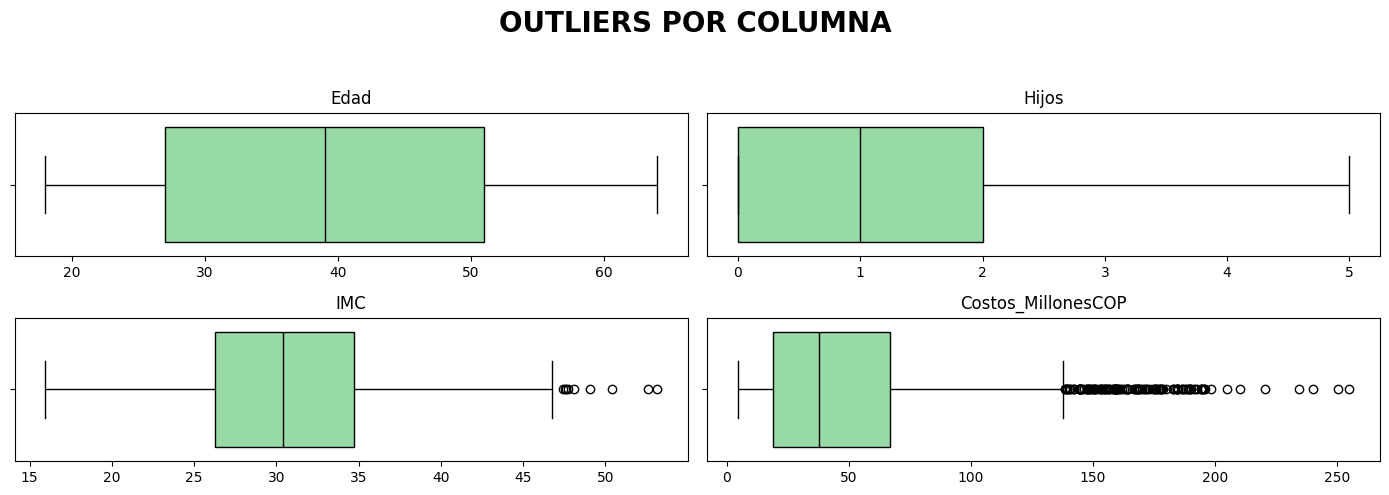

In [26]:
columnas = ['Edad', 'Hijos', 'IMC', 'Costos_MillonesCOP']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 5))

axes = axes.flatten()

for i, columna in enumerate(columnas):
    sns.boxplot(datos, x=columna, ax=axes[i], color='#8DE5A1', linecolor='black')
    axes[i].set_title(columna)
    axes[i].set_xlabel('')

plt.suptitle('OUTLIERS POR COLUMNA\n', fontsize=20, fontweight='bold')

plt.tight_layout()

plt.show()

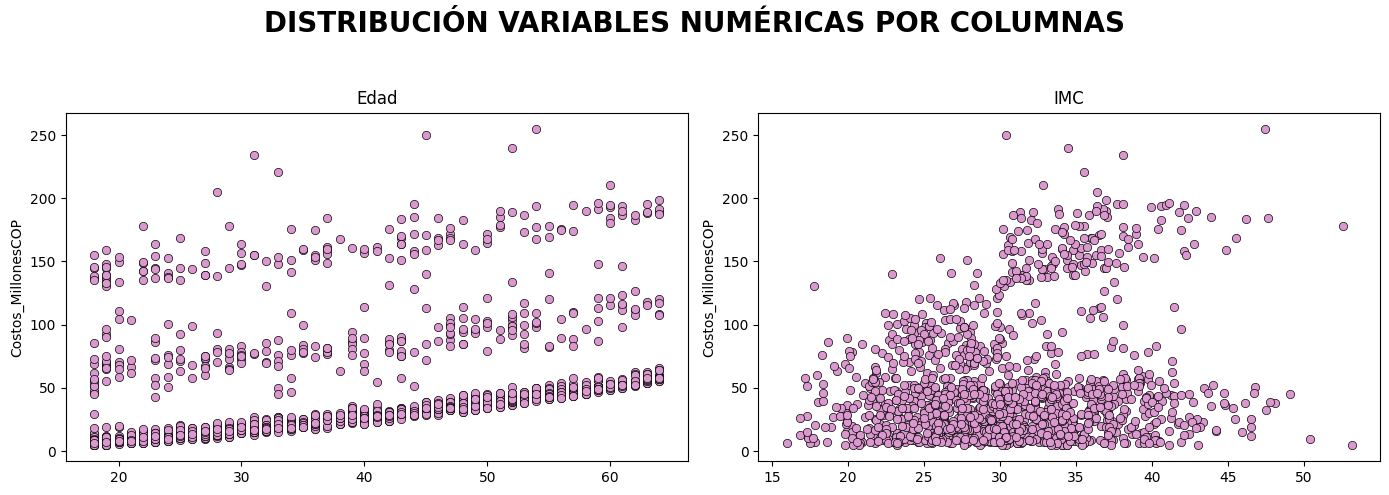

In [77]:
columnas = ['Edad', 'IMC']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axes = axes.flatten()

for i, columna in enumerate(columnas):
    sns.scatterplot(datos, x=columna, y='Costos_MillonesCOP', ax=axes[i], color='#DA98CE', edgecolor='black')
    axes[i].set_title(columna)
    axes[i].set_xlabel('')


plt.suptitle('DISTRIBUCIÓN VARIABLES NUMÉRICAS POR COLUMNAS\n', fontsize=20, fontweight='bold')

plt.tight_layout()

plt.show()

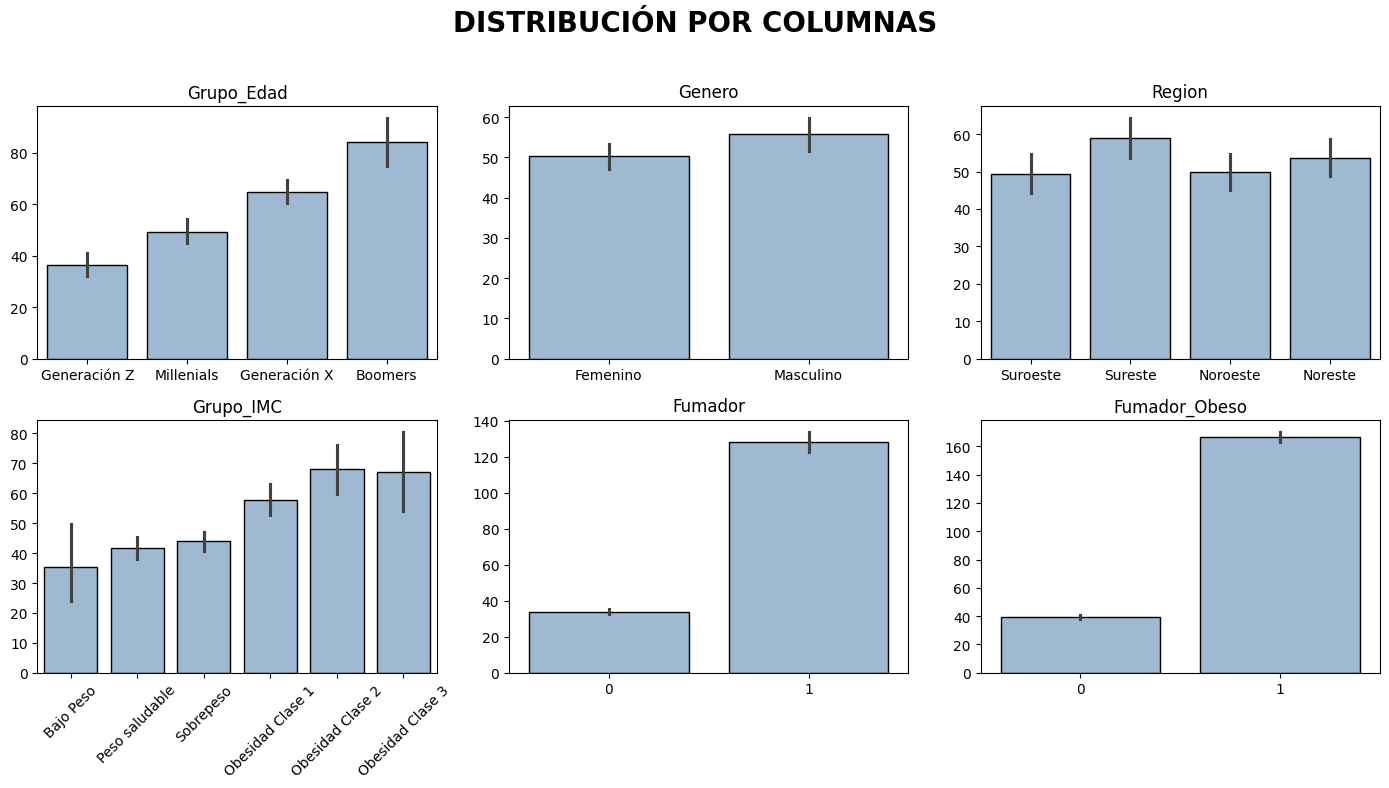

In [27]:
columnas = ['Grupo_Edad', 'Genero', 'Region', 'Grupo_IMC', 'Fumador', 'Fumador_Obeso']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(14, 8))

axes = axes.flatten()

for i, columna in enumerate(columnas):
    sns.barplot(datos, x=columna, y='Costos_MillonesCOP', ax=axes[i], color='#98B9DA', edgecolor='black')
    axes[i].set_title(columna)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    if columna == 'Grupo_IMC':
        axes[i].tick_params(axis='x', rotation=45)


plt.suptitle('DISTRIBUCIÓN VARIABLES CATEGÓRICAS POR COLUMNAS\n', fontsize=20, fontweight='bold')

plt.tight_layout()

plt.show()

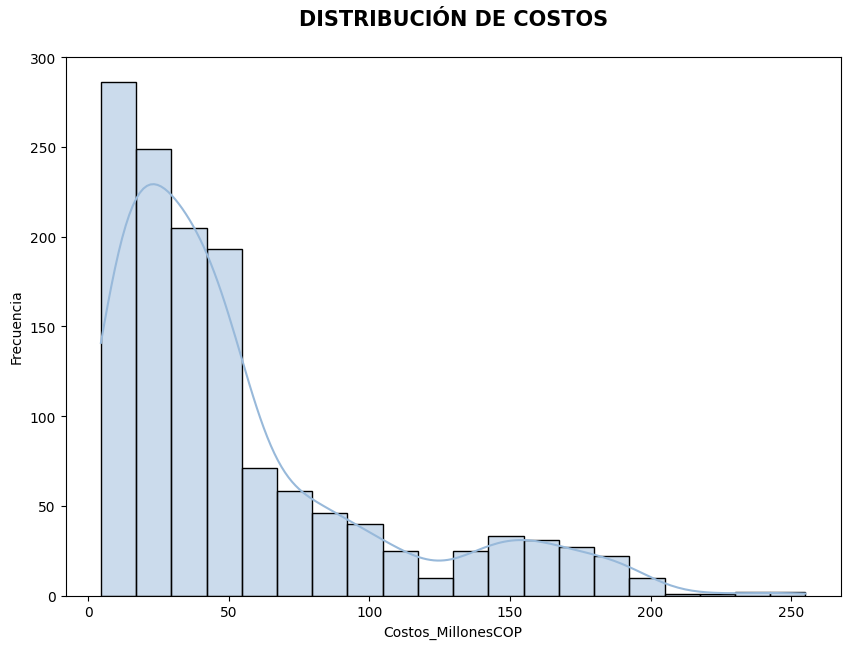

In [28]:
plt.figure(figsize=(10, 7))
sns.histplot(datos, x='Costos_MillonesCOP', bins=20, color='#98B9DA', kde=True)
plt.ylabel('Frecuencia')
plt.title('DISTRIBUCIÓN DE COSTOS\n',  fontsize=15, fontweight='bold')
plt.show()

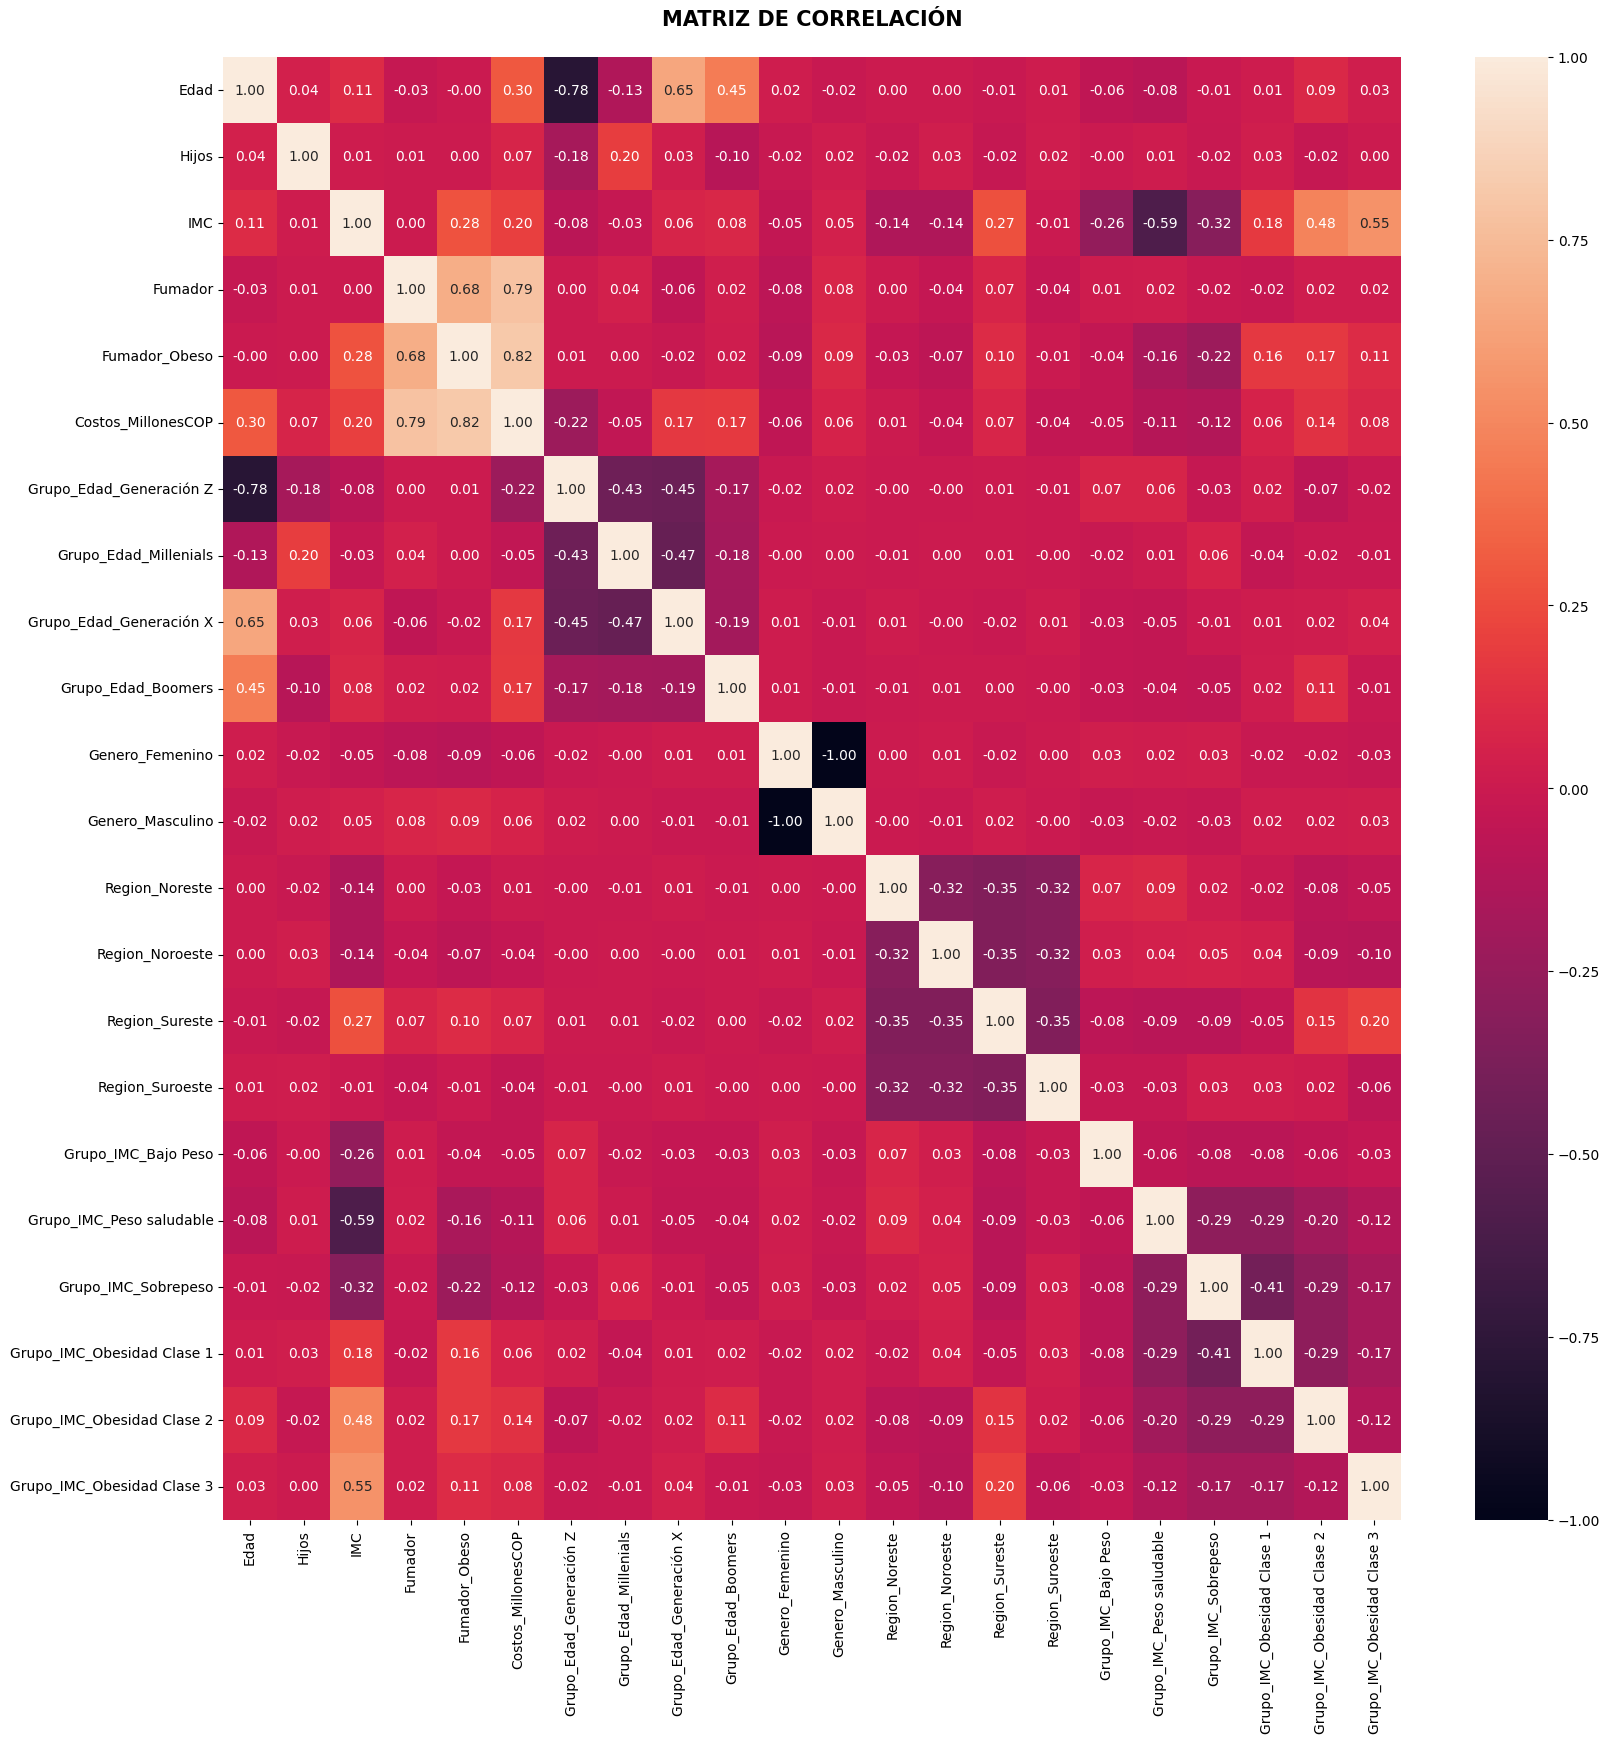

In [29]:
plt.figure(figsize=(19, 19))
datos_numericos = pd.get_dummies(datos)
correlacion = datos_numericos.corr()
sns.heatmap(correlacion, annot=True, fmt='.2f')
plt.title('MATRIZ DE CORRELACIÓN\n', fontsize=15, fontweight='bold')
plt.show()

# **CREACIÓN DEL MODELO**

In [30]:
datos_dummies = pd.get_dummies(datos, drop_first=True)

X = datos_dummies.drop("Costos_MillonesCOP", axis=1)
y = datos_dummies["Costos_MillonesCOP"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

modelo = LinearRegression()
modelo.fit(X_train_scaled, y_train)
y_pred = modelo.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"R²: {r2:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

cv_scores = cross_val_score(modelo, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"R² promedio en CV: {cv_scores.mean():.4f}")

R²: 0.90
RMSE: 16.82
MAE: 9.77
R² promedio en CV: 0.8505


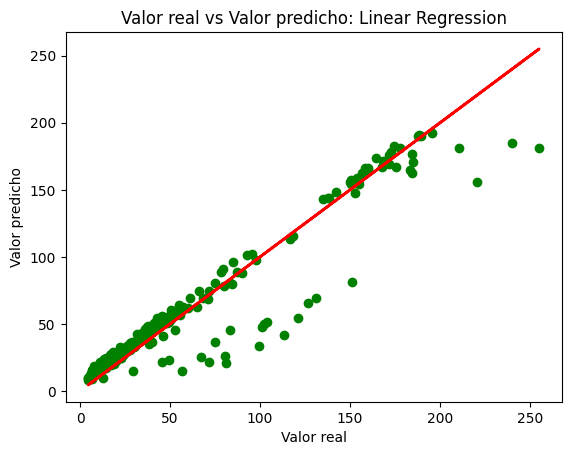

In [31]:
plt.scatter(y_test, y_pred, c='green')
plt.plot(y_test, y_test, color='red', linewidth=2)
plt.xlabel("Valor real")
plt.ylabel("Valor predicho")
plt.title("Valor real vs Valor predicho: Linear Regression")
plt.show()

In [32]:
joblib.dump(modelo, 'modelo_regresion.pkl')

['modelo_regresion.pkl']